In [1]:
import numpy as np
import pandas as pd
import sklearn.svm as svm
import sklearn.cluster as cl
from sklearn.metrics import balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import itertools
from typing import Dict
import random

In [1]:
from libs import data_lib
# print available data summary
_ = data_lib.explore_datasets(datafolder="Data",verbose=True)

import os
os.getcwd()

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: Data\6P-positive-dilution-series-1-labelled\droplet-level-data\RawData
po-di-se-1-A4, files: 13                po-di-se-1-B4, files: 13                po-di-se-1-C4, files: 13
po-di-se-1-D4, files: 13                po-di-se-1-A1, files: 13                po-di-se-1-B1, files: 13
po-di-se-1-C1, files: 13                po-di-se-1-D1, files: 13                
-----------------------------------
Group: Data\6P-positive-dilution-series-2-labelled\droplet-level-data\RawData
po-di-se-2-A4, files: 13                po-di-se-2-B4, files: 13                po-di-se-2-C4, files: 13
po-di-se-2-D4, files: 13                po-di-se-2-A1, files: 13                po-di-se-2-B1, files: 13
po-di-se-2-C1, files: 13                po-di

'c:\\Users\\ivanb\\Documents\\DataScienceLab\\dslab'

### Global Variables

In [3]:
features = ['Chan1_FluoValue',
       'Chan2_FluoValue', 'Chan3_FluoValue', 'Chan4_FluoValue',
       'Chan5_FluoValue', 'Chan6_FluoValue']

In [4]:
pathogens_long = ["IAV-M_POS",
             "IBV-M_POS",
             "MHV_POS",
             "RSV-N_POS",
             "SARS-N1_POS",
             "SARS-N2_POS"]

In [5]:
shorten_pathogens = {
    "IAV-M_POS": "IAV",
    "IBV-M_POS": "IBV",
    "MHV_POS": "MHV",
    "RSV-N_POS": "RSV",
    "SARS-N1_POS": "SARS-N1",
    "SARS-N2_POS": "SARS-N2"
}

In [6]:
pathogen_dict = {'SARS-N2': {0, 1},
                 'SARS-N1': {1, 2},
                 'RSV': {2, 3},
                 'IBV': {1, 2, 3},
                 'IAV': {4},
                 'MHV': {4, 5}}
pathogens = list(pathogen_dict.keys())
n_pathogens = len(pathogen_dict)
path_to_int = {path: i for (i, path) in enumerate(pathogens)}
int_to_path = {i: path for (path, i) in path_to_int.items()}

In [280]:
pathogens

['SARS-N2', 'SARS-N1', 'RSV', 'IBV', 'IAV', 'MHV']

# Functions

In [43]:
def pairwise_plots_dbscan(df, eps = 700, min_samples = 5):
    df = df[features]
    np_features = df.to_numpy()
    classifier = cl.DBSCAN(eps = eps, min_samples = min_samples)
    preds = classifier.fit_predict(np_features)

    
    print(f"Number of outliers: {len([x for x in preds if x == -1])}") # print number of outliers
    print(f"Number of clusters: {max(preds)+1}") # print number of clusters
    
    
    combinations = itertools.combinations(df.columns, 2)
    fig, ax = plt.subplots(5, 3, sharex=False, sharey=False)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i, combination in enumerate(combinations): 
        np_features = df.loc[:, combination]
        np_features = np_features.to_numpy()

        ax[i //3, i %3].set_xlabel(combination[0])
        ax[i //3, i %3].set_ylabel(combination[1])
        ax[i //3, i %3].scatter(np_features[:, 0], np_features[:, 1], c = preds)
    fig.tight_layout()

In [175]:
def selected_plot(df, cluster_ids: list):
    combinations = itertools.combinations(df[features], 2)
    fig, ax = plt.subplots(5, 3, sharex=False, sharey=False)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    df = df[df.cluster_preds.isin(cluster_ids)]
    cluster_preds = df.cluster_preds
    df = df[features]
    for i, combination in enumerate(combinations): 
        np_features = df.loc[:, combination]
        np_features = np_features.to_numpy()

        ax[i //3, i %3].set_xlabel(combination[0])
        ax[i //3, i %3].set_ylabel(combination[1])
        ax[i //3, i %3].scatter(np_features[:, 0], np_features[:, 1], c = cluster_preds)
    fig.tight_layout()

In [45]:
def make_preds(X, eps = 700, min_samples = 5):    
    clf = cl.DBSCAN(eps = eps, min_samples = min_samples)
    preds = clf.fit_predict(X)
    return preds

In [46]:
def find_zero_cluster(df : pd.DataFrame) -> int:
    #computing the size and norm of each cluster
    n_clusters = df.cluster_preds.unique().max()+1
    cluster_ids = list(range(n_clusters))
    avg_norms = np.zeros(n_clusters)
    
    get_norm = np.linalg.norm
    for cluster_id in cluster_ids:
        avg_norms[cluster_id] = df[df['cluster_preds'] == cluster_id][features].apply(get_norm, axis = 1).mean()
    
    return np.argmin(avg_norms)

In [261]:
def get_labelling(zero_cluster : np.ndarray, my_cluster : np.ndarray) -> list[bool]:
    dim = my_cluster.shape[1]
    zero_size = zero_cluster.shape[0]
    other_size = my_cluster.shape[0]
    active = []
    X = np.concatenate((zero_cluster, my_cluster))
    true_labels = np.array([0]*zero_size + [1]*other_size)

    for i in range(0, dim):        
        #true labels are both of our clusters concatenated
        
        clf = DecisionTreeClassifier(max_depth = 1)
        clf.fit(X[:, i].reshape(-1, 1), true_labels)
        #test how good the fit was
        score = balanced_accuracy_score(true_labels, clf.predict(X[:, i].reshape(-1, 1)))        
        
        if score > 0.9:
            active.append(1)
        else:
            active.append(0)
            
    return active

In [48]:
def get_activations(df, zero_cluster_id, cluster_ids) -> dict:
    
    zero_cluster = df[df.cluster_preds == zero_cluster_id][features].to_numpy()
    activ_dict = {}

    for cluster_id in cluster_ids:
        if cluster_id == zero_cluster_id:
            continue
        mask = df.cluster_preds == cluster_id
        cur_cluster = df[mask][features].to_numpy()
        activ = get_labelling(zero_cluster, cur_cluster)
        activ_dict[cluster_id] = activ
    return activ_dict

In [49]:
def _predict_pathogens(activations: list) -> list:
    pathogen_predictions = [1]*n_pathogens
    for pathogen, coords in pathogen_dict.items():
        for coord in coords:
            if activations[coord] != 1:
                pathogen_predictions[path_to_int[pathogen]] = 0
    return pathogen_predictions

In [50]:
def predict_pathogens(activations: dict) -> dict:
    pathogen_preds = {}
    for cluster_id, activ in activations.items():
        pathogen_preds[cluster_id] = _predict_pathogens(activ)
    return pathogen_preds

In [51]:
def postprocess_preds(preds: dict) -> dict:
    #to do
    # it should handle the case that if only MHV is present, then coordinate 4 is also kinda active so
    # it needs to check wheteher IAV is present (double positive) or not
    # and this in a general fashion to generalize well.
    return 

In [52]:
def remove_pathogens(df, removals):
    for removal in removals:
        mask = df[removal] == 0
        df = df[mask]
    return df.reset_index()

In [53]:
def processing_helper(x):
    pathogen_onehot = [0]*6
    for pathogen, presence in x.items():
        if presence:
            pathogen_onehot[path_to_int[pathogen]] = 1
    return pathogen_onehot

In [278]:
def make_labels(df: pd.DataFrame, pathogens = pathogens, return_dict = False):

    df["true_pathogens"] = df[pathogens].apply(lambda x: processing_helper(x), axis=1)    
    
    return df

In [154]:
def add_pathogen_preds(df, cluster_pathogen_preds):
    df['predicted_pathogens'] = [[0]*6]*len(df)
    for cluster_id, pathogen_preds in cluster_pathogen_preds.items():
        mask = df.cluster_preds == cluster_id
        
        df.loc[mask, "predicted_pathogens"] = df.loc[mask, "predicted_pathogens"].apply(lambda x: pathogen_preds)
    return df

## A3 Data Set ##
Identifying clusters on the **A3 data set**

In [185]:
df = data_lib.load_dataset(pathogens_long, ["wa-sa-A3"], 'Data')
df = df.rename(columns = shorten_pathogens)
df = make_labels(df)
X = df[features].to_numpy()

Number of outliers: 23
Number of clusters: 5


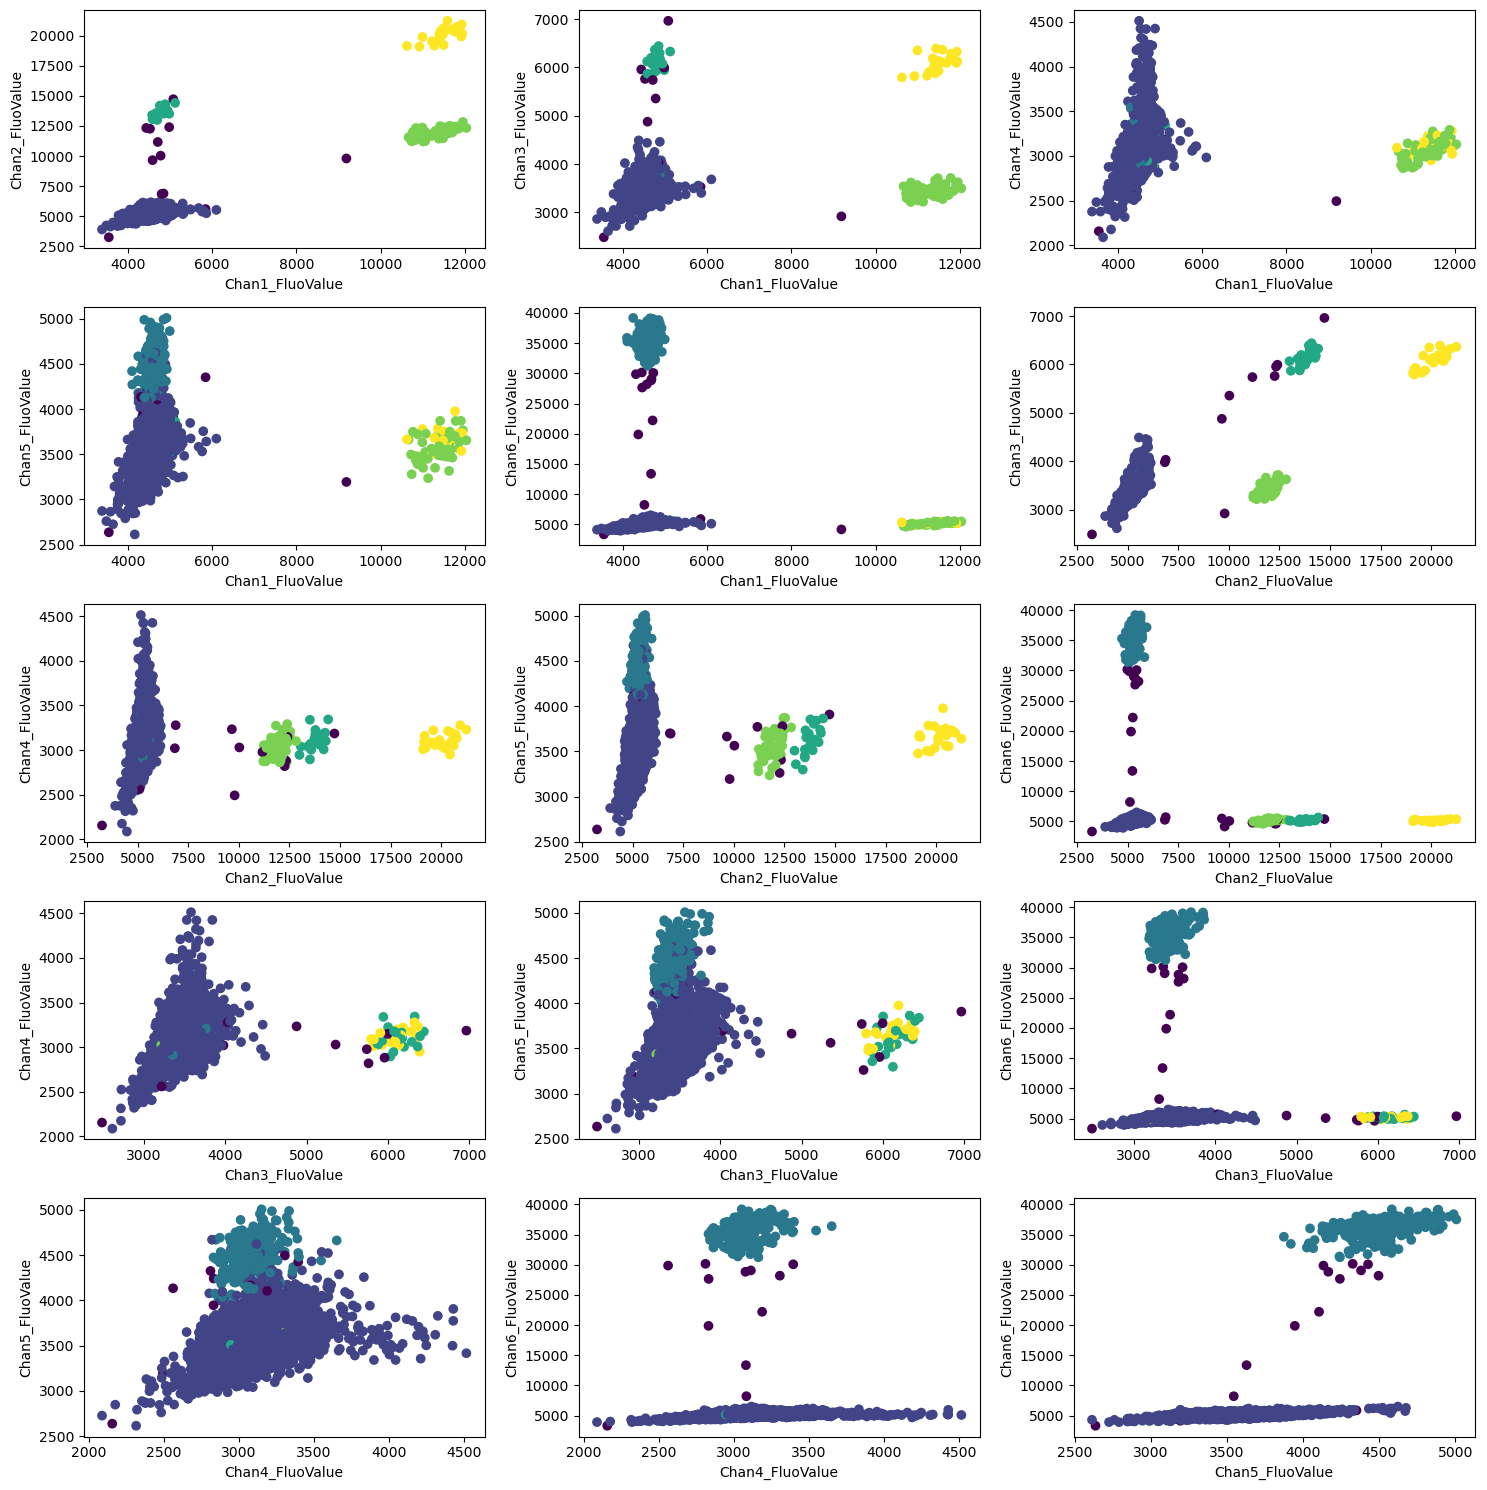

In [186]:
pairwise_plots_dbscan(df, eps = 700, min_samples = 5)

In [187]:
# making predictions
df['cluster_preds'] = make_preds(X)
n_clusters = df.cluster_preds.unique().max()+1
cluster_ids = list(range(n_clusters))

In [188]:
# finding zero cluster
zero_cluster_id = find_zero_cluster(df)
is_zero = lambda x: x == zero_cluster_id
zero_cluster_mask =  is_zero(df.cluster_preds)

In [189]:
activations = get_activations(df, zero_cluster_id, cluster_ids)

In [190]:
cluster_pathogen_preds = predict_pathogens(activations)

In [191]:
df = add_pathogen_preds(df, cluster_pathogen_preds)

In [192]:
df.predicted_pathogens.value_counts()

[0, 0, 0, 0, 0, 0]    18560
[0, 0, 0, 0, 1, 1]      293
[1, 0, 0, 0, 0, 0]       54
[1, 1, 0, 0, 0, 0]       22
[0, 1, 0, 0, 0, 0]       21
Name: predicted_pathogens, dtype: int64

In [193]:
df.true_pathogens.value_counts()

[0, 0, 0, 0, 0, 0]    18546
[0, 0, 0, 0, 0, 1]      302
[1, 0, 0, 0, 0, 0]       55
[0, 1, 0, 0, 0, 0]       25
[1, 1, 0, 0, 0, 0]       22
Name: true_pathogens, dtype: int64

## C3 Dataset

In [281]:
df = data_lib.load_dataset(pathogens_long, ["wa-sa-C3"], "Data")
df = df.rename(columns = shorten_pathogens)
considered_pathogens = ['SARS-N2', 'SARS-N1', 'IBV', 'MHV']
df = remove_pathogens(df, ['IAV', 'RSV'])
df = make_labels(df, considered_pathogens)
X = df[features].to_numpy()

Number of outliers: 42
Number of clusters: 11


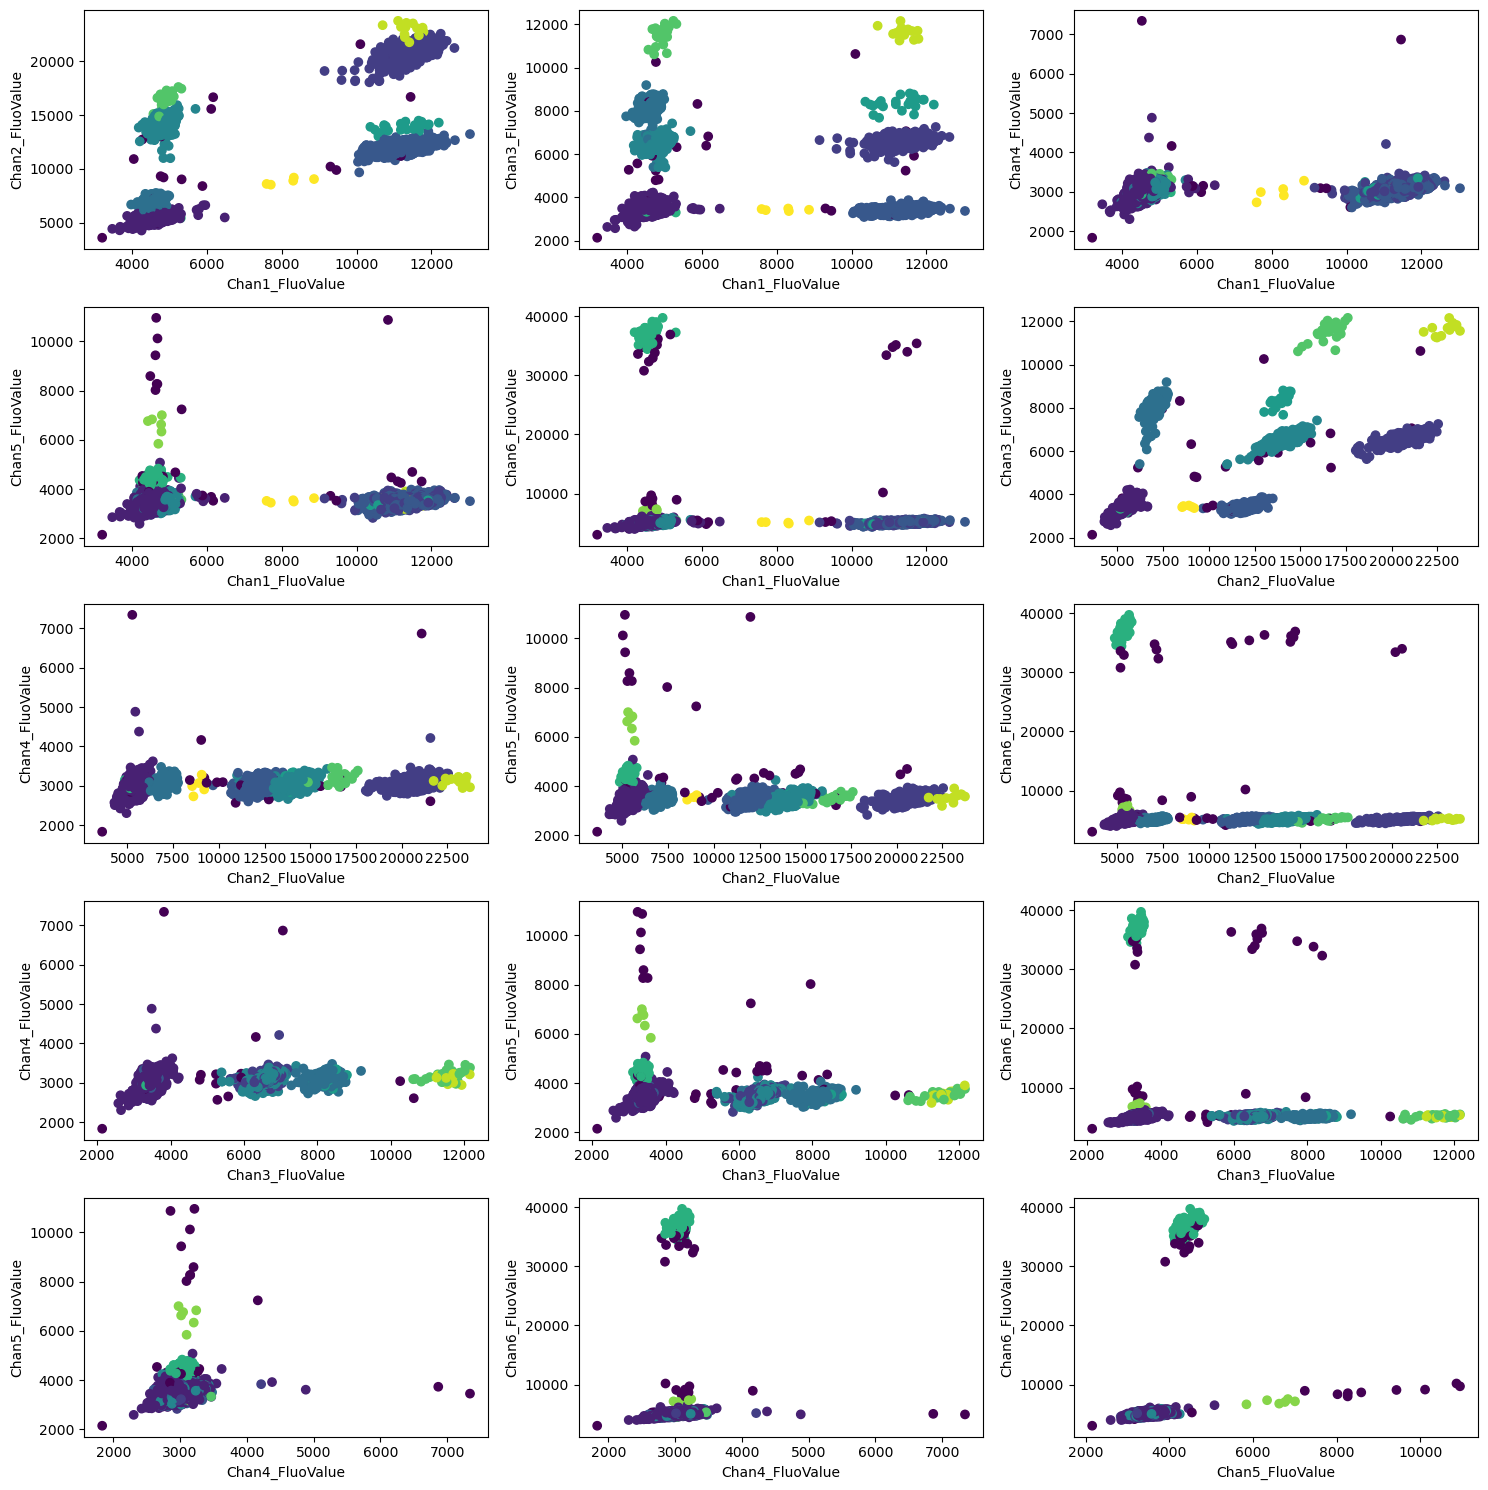

In [282]:
pairwise_plots_dbscan(df, eps = 1100, min_samples = 5)

In [283]:
# making predictions
df['cluster_preds'] = make_preds(X)
n_clusters = df.cluster_preds.unique().max()+1
cluster_ids = list(range(n_clusters))

In [284]:
n_clusters

10

In [285]:
# finding zero cluster
zero_cluster_id = find_zero_cluster(df)
is_zero = lambda x: x == zero_cluster_id
zero_cluster_mask =  is_zero(df.cluster_preds)

In [286]:
activations = get_activations(df, zero_cluster_id, cluster_ids)

In [287]:
activations

{1: [1, 1, 1, 0, 0, 0],
 2: [1, 1, 0, 0, 0, 0],
 3: [0, 1, 1, 0, 0, 0],
 4: [0, 1, 1, 0, 0, 0],
 5: [1, 1, 1, 0, 0, 0],
 6: [0, 0, 0, 0, 1, 1],
 7: [0, 1, 1, 0, 0, 0],
 8: [1, 1, 1, 0, 0, 0],
 9: [0, 0, 0, 0, 1, 1]}

In [298]:
def test(df):
    cluster_ids = [0, 1, 5, 8]
    combinations = itertools.combinations(df[features], 2)
    fig, ax = plt.subplots(5, 3, sharex=False, sharey=False)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    df = df[df.cluster_preds.isin(cluster_ids)]
    zero_cluster_mask_ = zero_cluster_mask[df[df.cluster_preds.isin(cluster_ids)].index]
    cluster_preds = df.cluster_preds
    df = df[features]
    for i, combination in enumerate(combinations): 
        np_features = df.loc[:, combination]
        np_features = np_features.to_numpy()

        ax[i //3, i %3].set_xlabel(combination[0])
        ax[i //3, i %3].set_ylabel(combination[1])
        ax[i //3, i %3].scatter(np_features[:, 0], np_features[:, 1], c = zero_cluster_mask_)
    fig.tight_layout()

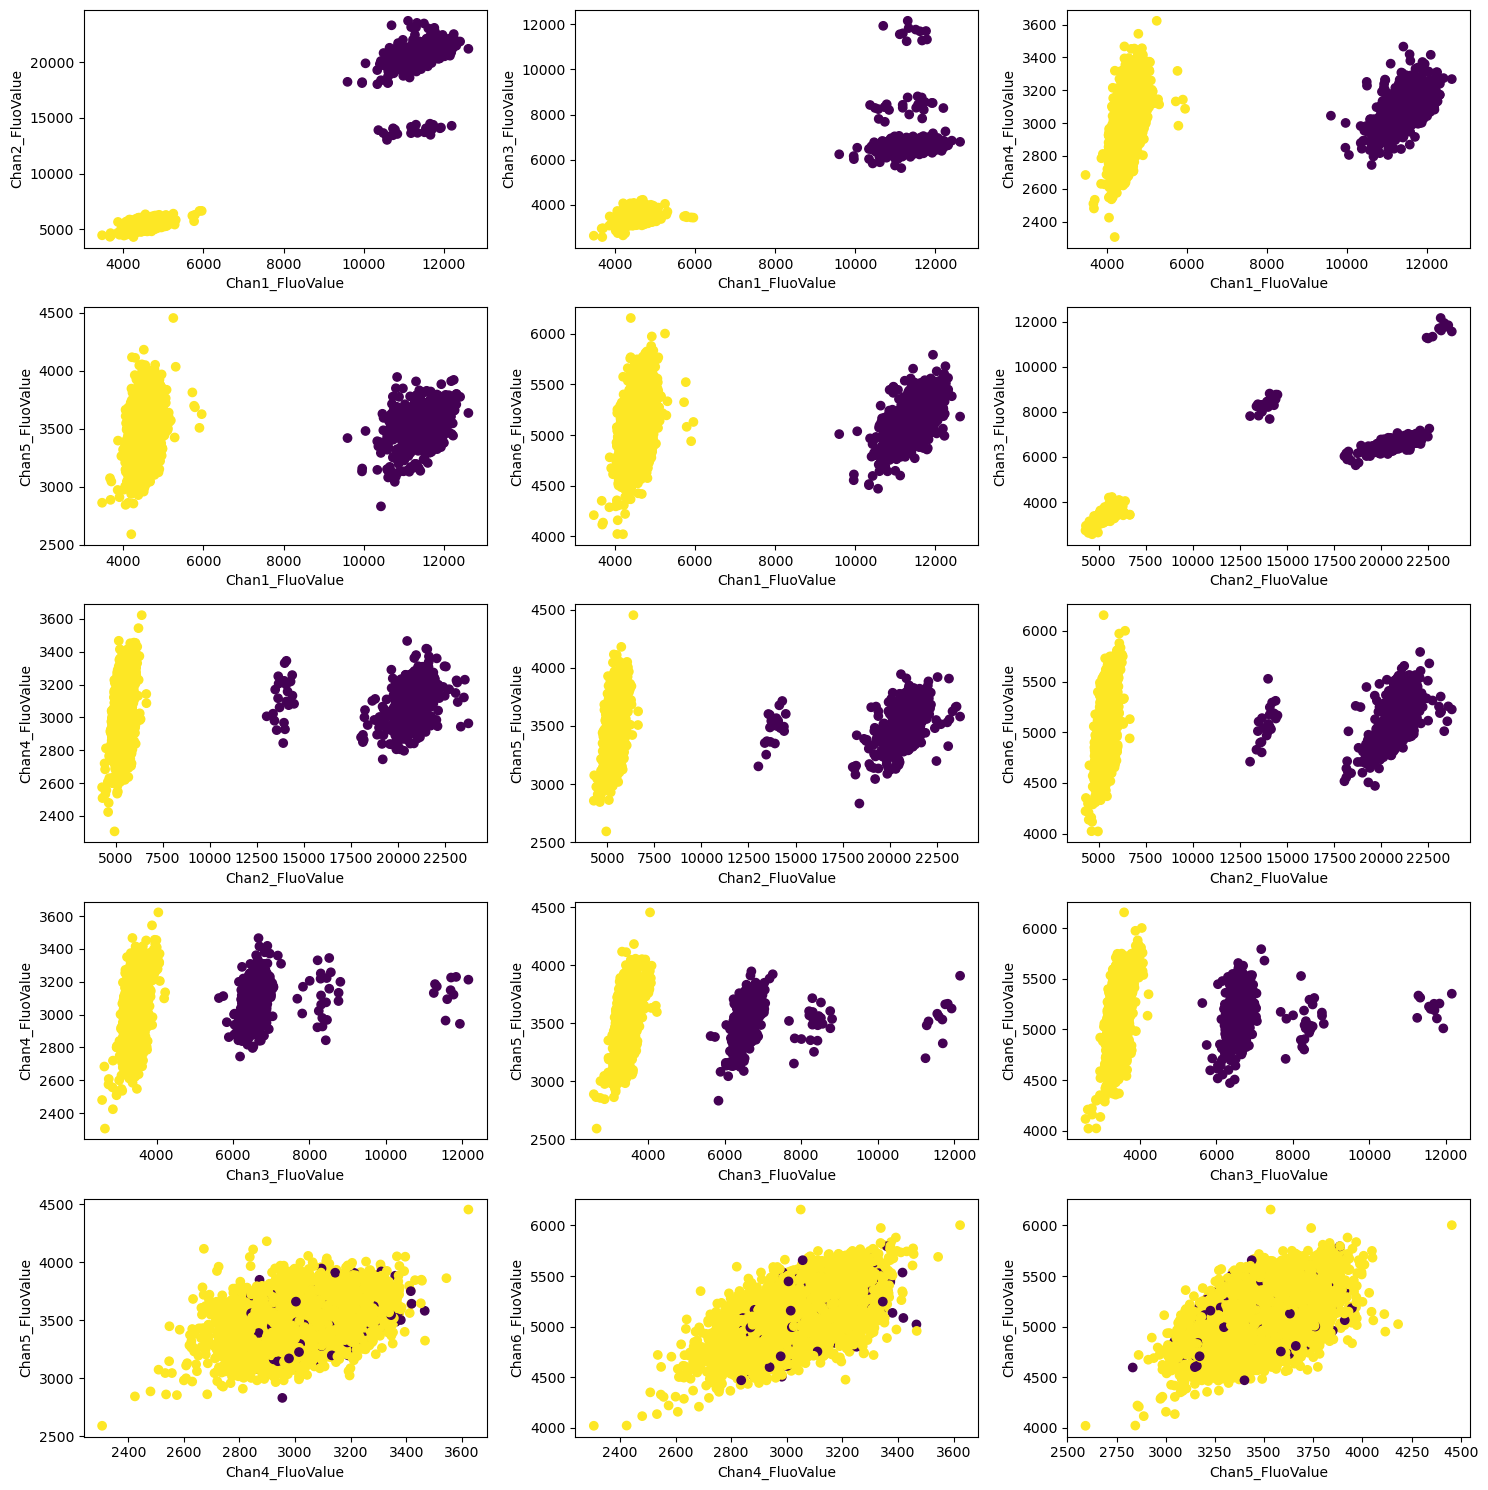

In [299]:
test(df)

In [ ]:
# das entspricht den folgenden labels:
# n1 und n2
# n2 und IBV
# n1 und n2 und IBV

In [289]:
cluster_pathogen_preds = predict_pathogens(activations)

In [290]:
int_to_path

{0: 'SARS-N2', 1: 'SARS-N1', 2: 'RSV', 3: 'IBV', 4: 'IAV', 5: 'MHV'}

In [291]:
cluster_pathogen_preds

{1: [1, 1, 0, 0, 0, 0],
 2: [1, 0, 0, 0, 0, 0],
 3: [0, 1, 0, 0, 0, 0],
 4: [0, 1, 0, 0, 0, 0],
 5: [1, 1, 0, 0, 0, 0],
 6: [0, 0, 0, 0, 1, 1],
 7: [0, 1, 0, 0, 0, 0],
 8: [1, 1, 0, 0, 0, 0],
 9: [0, 0, 0, 0, 1, 1]}

In [292]:
df = add_pathogen_preds(df, cluster_pathogen_preds)

In [293]:
df.predicted_pathogens.value_counts()

[0, 0, 0, 0, 0, 0]    12837
[0, 1, 0, 0, 0, 0]     1283
[1, 0, 0, 0, 0, 0]      880
[1, 1, 0, 0, 0, 0]      542
[0, 0, 0, 0, 1, 1]       66
Name: predicted_pathogens, dtype: int64

In [294]:
df.true_pathogens.value_counts()

[0, 0, 0, 0, 0, 0]    12803
[0, 1, 0, 0, 0, 0]      936
[1, 0, 0, 0, 0, 0]      889
[1, 1, 0, 0, 0, 0]      514
[0, 0, 0, 1, 0, 0]      321
[0, 0, 0, 0, 0, 1]       67
[0, 1, 0, 1, 0, 0]       28
[1, 0, 0, 1, 0, 0]       23
[1, 1, 0, 1, 0, 0]       14
[0, 1, 0, 0, 0, 1]        5
[0, 0, 0, 1, 0, 1]        3
[1, 0, 0, 0, 0, 1]        3
[1, 1, 0, 0, 0, 1]        2
Name: true_pathogens, dtype: int64